In [ ]:
# default_exp funcs.output_trafo

In [ ]:
%load_ext autoreload
%autoreload 2

# Transformations of sampled data and model output into emitter dataframes

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
import torch.nn.functional as F
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import * 

In [ ]:
#export
def sample_to_df(locs, x_os, y_os, z_os, ints, px_size_zyx=[100,100,100], channels=16, n_bits=4):
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 
    
    b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0], 
                        torch.tensor([len(x_os)], device=x_os.device)])
    n_gt = len(b_inds) - 1

    frame_idx = locs[0]
    ch_idx = locs[1]
    
    loc_idx = []
    for i in range(n_gt):
        loc_idx += [i] * (b_inds[i+1] - b_inds[i])
    
    df = DF({'loc_idx': loc_idx,
             'frame_idx': frame_idx.cpu(),
             'ch_idx': ch_idx.cpu(),
             'x': x.cpu()*px_size_zyx[2],
             'y': y.cpu()*px_size_zyx[1], 
             'z': z.cpu()*px_size_zyx[0],
             'int': ints.cpu()}) 
    
    int_arr = np.zeros([n_gt, channels])
    int_arr[df['loc_idx'], df['ch_idx']] = ints.cpu()
    
    df = df.iloc[cpu(b_inds[:-1])]
    for i in range(16):
        df[f'int_{i}'] = int_arr[:,i]

    return df

def df_to_micro(df, px_size_zyx=[100,100,100]):
    
    locs = tuple([torch.tensor(df['frame_idx'],dtype=torch.int64).cuda(),
                 torch.zeros(len(df),dtype=torch.int64).cuda(),
                 torch.tensor((df['z']/px_size_zyx[0] + 0.5),dtype=torch.int64).cuda(),
                 torch.tensor((df['y']/px_size_zyx[1] + 0.5),dtype=torch.int64).cuda(),
                 torch.tensor((df['x']/px_size_zyx[2] + 0.5),dtype=torch.int64).cuda()])
    z = (torch.tensor(df['z'],dtype=torch.float32).cuda()-locs[2]*px_size_zyx[0])/px_size_zyx[0] - 0.5
    y = (torch.tensor(df['y'],dtype=torch.float32).cuda()-locs[3]*px_size_zyx[1])/px_size_zyx[1] - 0.5
    x = (torch.tensor(df['x'],dtype=torch.float32).cuda()-locs[4]*px_size_zyx[2])/px_size_zyx[2] - 0.5
    ints = torch.tensor(df['int']).cuda()

    return locs, x, y, z, ints

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = PointProcessUniform(torch.ones([1,1,40,40,40])*0.001).sample()
sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d)

,loc_idx,frame_idx,ch_idx,x,y,z,int
0,0,0,0,2200.548828,2430.385254,277.723022,1.0
1,1,0,0,193.231110,3384.383789,523.696716,1.0
2,2,0,0,2674.264648,2356.520996,698.128052,1.0
3,3,0,0,2517.949951,3655.729004,761.740234,1.0
4,4,0,0,1689.521606,64.096130,1646.866943,1.0
5,5,0,0,2276.050293,1455.689941,1657.295166,1.0
6,6,0,0,3998.210938,3751.784424,1952.473022,1.0
7,7,0,0,3693.832031,1459.244873,2113.261963,1.0
8,8,0,0,3228.084473,3359.571045,2206.432373,1.0
9,9,0,0,625.281799,2402.159424,2323.377686,1.0


In [ ]:
#export
class SIPostProcess(torch.nn.Module):
    
    def __init__(self, m1_threshold:float = 0.03, m2_threshold:float = 0.3, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=0):
        
        super().__init__()
        self.m1_threshold = m1_threshold
        self.m2_threshold = m2_threshold
        self.samp_threshold = samp_threshold
        self.diag = diag
        self.px_size_zyx = px_size_zyx
        
        if not diag:
            d1 = 0; d2 = 0
        else:
            d1 = 1/np.sqrt(2); d2 = 1/np.sqrt(3)
#             d1 = 1; d2 = 1
        self.filt = torch.FloatTensor([[[d2,d1,d2],[d1,1,d1],[d2,d1,d2]],
                                       [[d1, 1,d1],[1, 1, 1],[d1, 1,d1]],
                                       [[d2,d1,d2],[d1,1,d1],[d2,d1,d2]]])[None,None]
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)

        with torch.no_grad():

            p_copy = p + 0

            # probability values > threshold are regarded as possible locations
            p_clip = torch.where(p>self.m1_threshold,p,torch.zeros_like(p))

            # localize maximum values within a 3x3 patch
            pool = F.max_pool3d(p_clip,3,1,padding=1)
            max_mask1 = torch.eq(p, pool).float()

            # Add probability values from the 4 adjacent pixels
            conv = F.conv3d(p, self.filt.to(device) ,padding=1)
            p_ps1 = (max_mask1 * conv)

            # In order do be able to identify two fluorophores in adjacent pixels we look for probablity values > 0.5 that are not part of the first mask

            p_copy *= (1-max_mask1)
            p_clip = torch.where(p_copy>self.m2_threshold, p_copy,torch.zeros_like(p_copy))
            max_mask2 = torch.where(p_copy>self.m2_threshold, torch.ones_like(p_copy),torch.zeros_like(p_copy))
            p_ps2 = max_mask2*conv

            # This is our final clustered probablity which we then threshold (normally > 0.7) to get our final discrete locations 
            p_ps = p_ps1 + p_ps2        

            return p_ps
        
    def get_si_resdict(self, res_dict, p_si=None):
        
        if p_si is None:
            p_si = self.forward(res_dict['logits'])
            
        res_dict['Probs_si'] = p_si
        res_dict['Samples_si'] = torch.where(res_dict['Probs_si'] > self.samp_threshold, torch.ones_like(res_dict['Probs_si']), torch.zeros_like(res_dict['Probs_si']))
        
        return res_dict
        
    def get_df(self, res_dict, p_si=None):
        
        res_dict = self.get_si_resdict(res_dict, p_si)
        
        res_dict = {k:v.cpu() for (k,v) in res_dict.items()}
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)

        pos_x, pos_y, pos_z = locations[-1] ,locations[-2], locations[-3]
        x = pos_x + res_dict['xyzi_mu'][:,[0]][locations] + 0.5 
        y = pos_y + res_dict['xyzi_mu'][:,[1]][locations] + 0.5 
        z = pos_z + res_dict['xyzi_mu'][:,[2]][locations] + 0.5 

        loc_idx = torch.arange(len(x))
        frame_idx = locations[0]

        df = DF({'loc_idx': loc_idx,
                 'frame_idx': frame_idx,
                 'x': x*self.px_size_zyx[2],
                 'y': y*self.px_size_zyx[1], 
                 'z': z*self.px_size_zyx[0], 
                 'prob': res_dict['Probs_si'][locations], 
                 'int': res_dict['xyzi_mu'][:,[3]][locations], 
                 'int_sig': res_dict['xyzi_sigma'][:,[3]][locations], 
                 'x_sig': res_dict['xyzi_sigma'][:,[0]][locations]*self.px_size_zyx[0], 
                 'y_sig': res_dict['xyzi_sigma'][:,[1]][locations]*self.px_size_zyx[1], 
                 'z_sig': res_dict['xyzi_sigma'][:,[2]][locations]*self.px_size_zyx[2],
                 'comb_sig': torch.sqrt(res_dict['xyzi_sigma'][:,[0]][locations]**2
                                       +res_dict['xyzi_sigma'][:,[1]][locations]**2
                                       +res_dict['xyzi_sigma'][:,[2]][locations]**2)})
        
        for i in range(16):
            df[f'int_{i}'] = res_dict['xyzi_mu'][:,[3+i]][locations]
            df[f'int_sig_{i}'] = res_dict['xyzi_sigma'][:,[3+i]][locations]

        return df
        
    def get_micro_inp(self, res_dict, p_si=None, channel=0):
        
        res_dict = self.get_si_resdict(res_dict, p_si)
        
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)
        locations = [l for l in locations]
        x_os_3d = res_dict['xyzi_mu'][:,[0]][locations]
        y_os_3d = res_dict['xyzi_mu'][:,[1]][locations]
        z_os_3d = res_dict['xyzi_mu'][:,[2]][locations]
        ints_3d = res_dict['xyzi_mu'][:,[3+channel]][locations] 
        output_shape  = res_dict['Samples_si'].shape

        return locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape

# p_col = []

In [ ]:
#export
class ISIPostProcess(SIPostProcess):
    
    def __init__(self, m1_threshold:float = 0.1, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=False):
        
        super().__init__(m1_threshold = m1_threshold, samp_threshold=samp_threshold, px_size_zyx=px_size_zyx, diag=diag)
        self.m2_threshold = None
        
    def forward(self, logits):

        device = logits.device
        count = 0
        p = torch.sigmoid(logits)
        
        with torch.no_grad():
            
            p_ret = 0
            tot_mask = torch.ones_like(p)
#             count_arr = torch.zeros_like(p)
            
            while True:
                
                count += 1

                # probability values > threshold are regarded as possible locations
                p_clip = torch.where(p>self.m1_threshold,p,torch.zeros_like(p))*tot_mask

                # localize maximum values within a 3x3 patch
                pool = F.max_pool3d(p_clip,3,1,padding=1)
                max_mask1 = torch.eq(p, pool).float()
                max_mask1[p==0] = 0
                
#                 count_arr += max_mask1*count
                
                tot_mask *= (torch.ones_like(max_mask1) - max_mask1)
                
                # Add probability values from the adjacent pixels
                conv = F.conv3d(p, self.filt.to(device) ,padding=1)
                p_ps = max_mask1 * conv
                
                p_ret += torch.clamp_max(p_ps, 1) 
                
                p_fac = 1/p_ps
                p_fac[torch.isinf(p_fac)] = 0
                p_fac = torch.clamp_max(p_fac, 1) 
                p_proc = F.conv3d(p_fac, self.filt.to(device),padding=1)*p

                p = p - p_proc
                torch.clamp_min_(p, 0)
                
                if not max_mask1.sum():
                    break
            
            return p_ret #, count_arr
        
#                 plt.figure(figsize=(20,5))
#                 plt.subplot(141)
#                 plt.imshow(cpu(p[0,0][sl[1:]]).sum(0))
#                 plt.subplot(142)
#                 plt.imshow(cpu(p_ps[0,0][sl[1:]]).sum(0))
#                 plt.title(cpu(p_ps[0,0][sl[1:]]).sum())
#                 plt.colorbar()
#                 plt.subplot(143)
#                 plt.imshow(cpu(p_proc[0,0][sl[1:]]).sum(0))
#                 plt.title(cpu(p_proc[0,0][sl[1:]]).sum())
#                 plt.colorbar()
#                 plt.show()

In [ ]:
class ISIPostProcess(SIPostProcess):
    
    def __init__(self, m1_threshold:float = 0.1, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=False):
        
        super().__init__(m1_threshold = m1_threshold, samp_threshold=samp_threshold, px_size_zyx=px_size_zyx, diag=diag)
        self.m2_threshold = None
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)
        
        with torch.no_grad():
            
            p_SI = 0
            tot_mask = torch.ones_like(p)
            max_mask = torch.ones_like(p)
            
            while max_mask.sum():
                
                # voxels with probability values > threshold,
                # and which where not previously counted as locations, are canditates
                p_cand = torch.where(p>self.m1_threshold, p, torch.zeros_like(p)) * tot_mask

                # localize maximum (nonzero) values within a 3x3x3 volume
                p_cand = F.max_pool3d(p_cand,3,1,padding=1)
                max_mask = torch.eq(p, p_cand).float()
                max_mask[p==0] = 0
                
                # Add up probability values from the adjacent pixels
                conv = F.conv3d(p, self.filt.to(device), padding=1)
                p_sum = max_mask * conv
                
                # Add the integrated probabilities to the return tensor. 
                p_SI += torch.clamp_max(p_sum, 1) 
                # Voxels that where added can not be added again
                tot_mask *= (torch.ones_like(max_mask) - max_mask)
                
                # The probability mass that contributed to p_sum is removed.
                p_fac = 1/p_sum
                p_fac[torch.isinf(p_fac)] = 0
                p_fac = torch.clamp_max(p_fac, 1) 
                p_proc = F.conv3d(p_fac, self.filt.to(device),padding=1)*p

                p = p - p_proc
                torch.clamp_min_(p, 0)
            
            return p_SI

In [ ]:
from decode_fish.funcs.utils import *
# model_out = torch.load('../data/model_output.pt')
# probs_inp = torch.sigmoid(model_out['logits'])[:,:,:,250:300,200:250]

# model_out = torch.load('../data/model_batch_output.pt')
# probs_inp = torch.sigmoid(model_out['logits'])

# model_out = torch.load('../data/model_output_t.pt')
# probs_inp = torch.sigmoid(model_out['logits'])[:,:,:,:,:]

model_out = torch.load('../data/model_output_2d.pt')
probs_inp = torch.sigmoid(model_out['logits'])

# gt_df = torch.load('../data/gt_1.pt')
# len(gt_df)

In [ ]:
from decode_fish.funcs.evaluation import *

post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.25, samp_threshold=0.6, px_size_zyx=[100,100,100], diag=True)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)

# matching(px_to_nm(gt_df),  post_proc1.forward(model_out, ret='df'), tolerance=500, print_res=True)
# _=matching(px_to_nm(gt_df),  post_proc2.forward(model_out, ret='df'), tolerance=500, print_res=True)

In [ ]:
# probs_inp = probs_inp[:,:,10:11]
# for k in model_out:
#     model_out[k] = model_out[k][:,:,10:11]

Text(0.5, 1.0, '37.0')

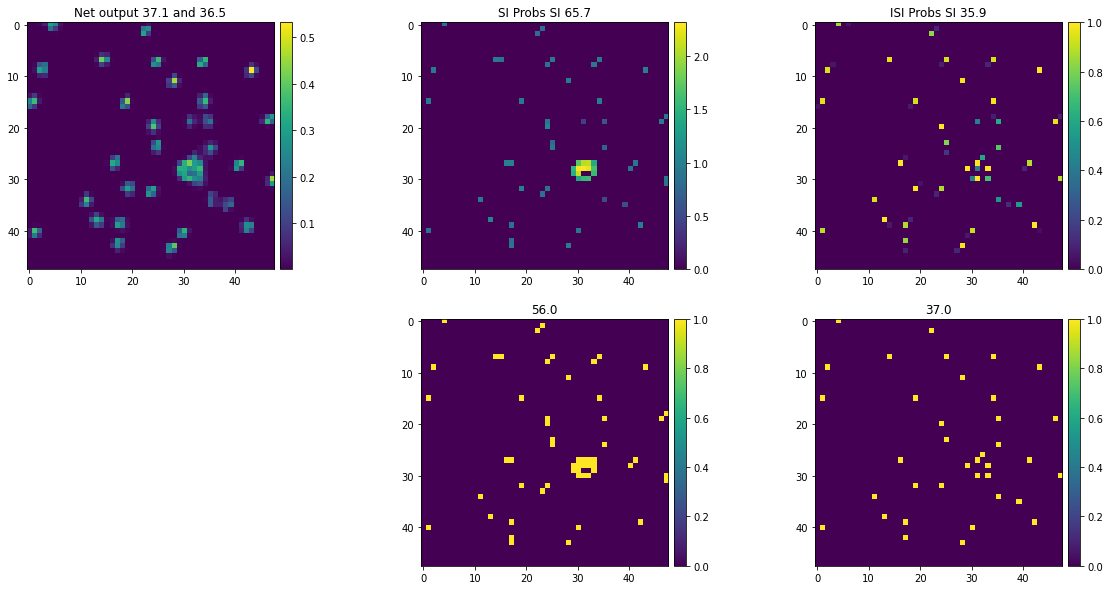

In [ ]:
# print(len(gt_df))
plt.figure(figsize=(20,10))
plt.subplot(231)
probs = cpu(probs_inp[0,0])
probsf = probs + 0
probsf[probsf<0.01] = 0
im = plt.imshow(probs.sum(0))
# plt.scatter(gt_df['x'],gt_df['y'], color='red', s=5.)
plt.title(f'Net output {probs.sum().item():.1f} and {probsf.sum().item():.1f}'.format())
add_colorbar(im)

recs = post_proc1.get_si_resdict(model_out)
plt.subplot(232)
im = plt.imshow(cpu(recs['Probs_si'][0,0]).max(0))
add_colorbar(im)
N = cpu(recs['Probs_si'][0,0]).sum().item()
plt.title(f'SI Probs SI {N:.1f}')

plt.subplot(235)
im = plt.imshow(cpu(recs['Samples_si'][0,0]).sum(0))
add_colorbar(im)
plt.title(cpu(recs['Samples_si'][0,0]).sum().item())

recs = post_proc2.get_si_resdict(model_out)
plt.subplot(233)
im = plt.imshow(cpu(recs['Probs_si'][0,0]).max(0))
add_colorbar(im)
N = cpu(recs['Probs_si'][0,0]).sum().item()
plt.title(f'ISI Probs SI {N:.1f}')

plt.subplot(236)
im = plt.imshow(cpu(recs['Samples_si'][0,0]).sum(0))
add_colorbar(im)
plt.title(cpu(recs['Samples_si'][0,0]).sum().item())

In [ ]:
sl = np.s_[:,:10,35:45,20:30]
gt_sub = crop_df(gt_df, sl)
p_sub = crop_df(nm_to_px(post_proc2.forward(model_out, ret='df')), sl)
axes=plot_3d_projections(probs[sl[1:]], 'max', size=15)
# print(probs[sl[1:]].sum(), len(gt_sub), len(p_sub))
# axes[0].scatter(gt_sub['x'],gt_sub['y'], color='red', s=5.)
# axes[1].scatter(gt_sub['x'],gt_sub['z'], color='red', s=5.)
# axes[2].scatter(gt_sub['y'],gt_sub['z'], color='red', s=5.)

axes[0].scatter(p_sub['x'],p_sub['y'], color='red', s=15.)
axes[1].scatter(p_sub['x'],p_sub['z'], color='red', s=15.)
axes[2].scatter(p_sub['y'],p_sub['z'], color='red', s=15.)

In [ ]:
p.shape

torch.Size([1, 1, 48, 48, 48])

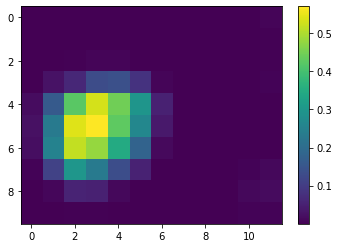

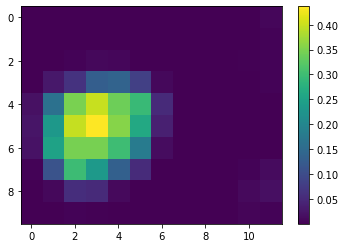

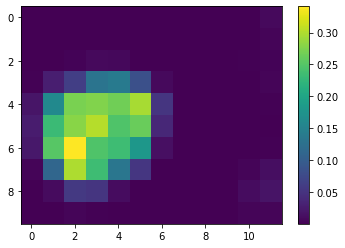

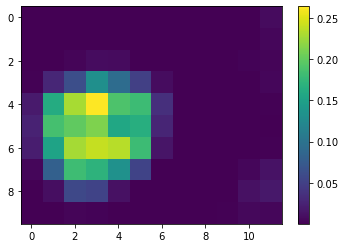

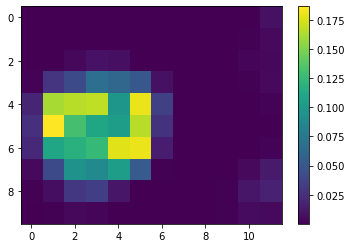

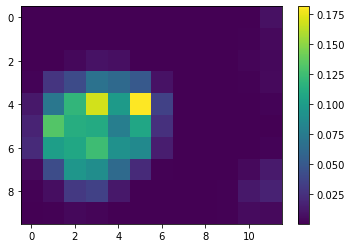

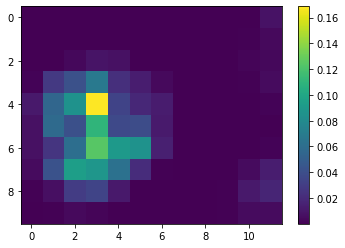

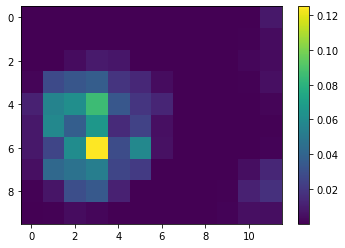

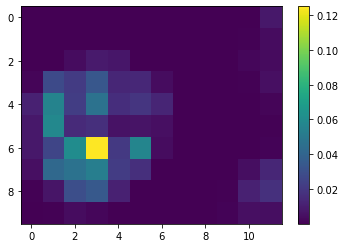

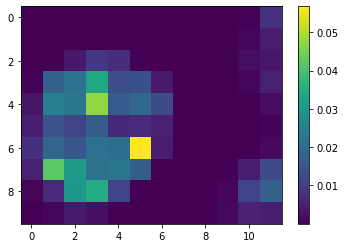

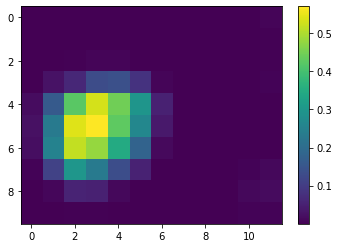

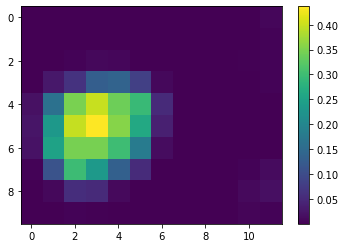

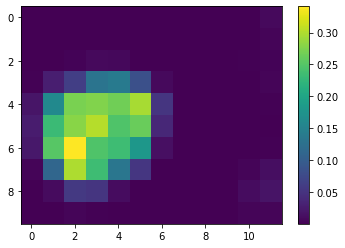

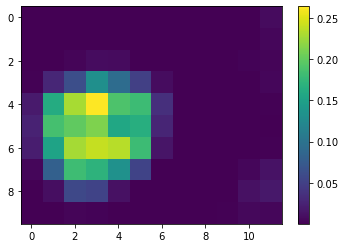

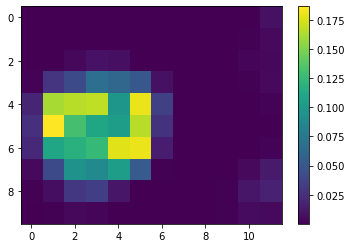

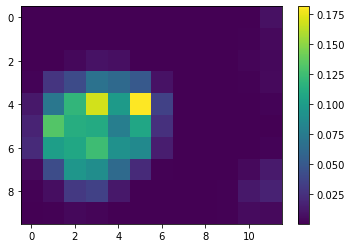

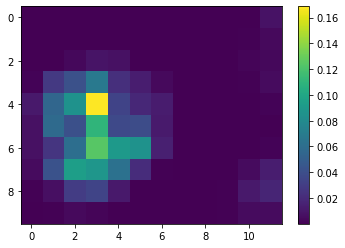

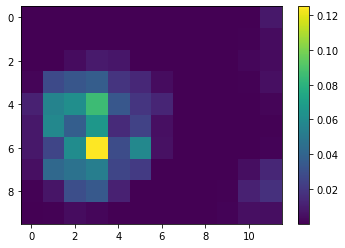

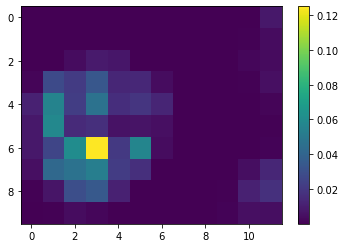

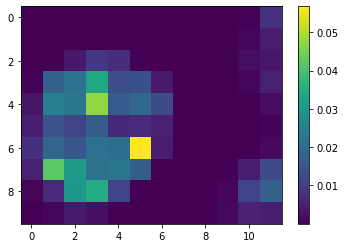

In [ ]:
for p in p_col:
    plt.imshow(cpu(p[0,0][sl[1:]]).max(0))
#     plt.title(cpu(p[0,0][sl[1:]]).sum())
    plt.colorbar()
    plt.show()

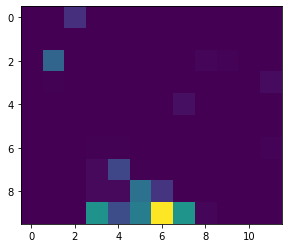

In [ ]:
plt.imshow(cpu(p[0,0][sl[1:]]).max(0))

(array([1.10259e+05, 2.06000e+02, 5.20000e+01, 3.10000e+01, 1.30000e+01,
        1.10000e+01, 7.00000e+00, 8.00000e+00, 0.00000e+00, 5.00000e+00]),
 array([2.4743142e-05, 7.3928811e-02, 1.4783287e-01, 2.2173694e-01,
        2.9564101e-01, 3.6954507e-01, 4.4344914e-01, 5.1735324e-01,
        5.9125727e-01, 6.6516137e-01, 7.3906541e-01], dtype=float32),
 <BarContainer object of 10 artists>)

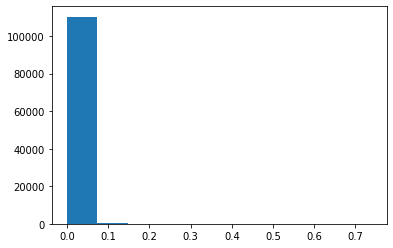

In [ ]:
plt.hist(probs.reshape(-1).numpy())

Text(0.5, 1.0, '2.4885129928588867')

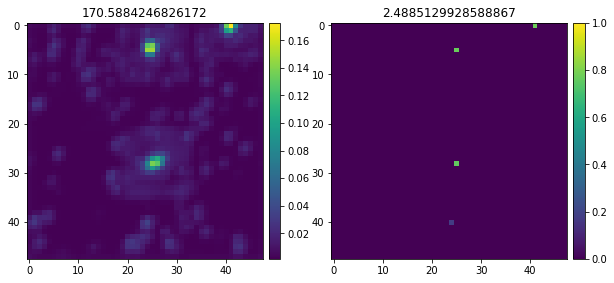

In [ ]:
probs_si = post_proc.spatial_integration(probs_inp)

plt.figure(figsize=(10,5))
plt.subplot(121)
probs = probs_inp[0,0].detach().cpu()
# probs[probs<0.01] = 0
im = plt.imshow(probs.max(dim=0).values)
plt.title(probs.sum().item())
add_colorbar(im)
plt.subplot(122)
im = plt.imshow(probs_si[0,0].cpu().max(dim=0).values, vmax=1)
add_colorbar(im)
plt.title(probs_si[0].sum().item())

In [ ]:
model_out = torch.load('../data/model_output_1.pt')
out_df = post_proc2(model_out)
out_df

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig
0,0,0,811.790955,1518.304199,100.611565,0.171860,0.746066,0.181192,9.735320,9.856243,17.009920
1,1,0,757.667969,513.304199,95.219490,0.739548,0.795610,0.101314,4.362606,4.324372,6.956621
2,2,0,810.451111,1522.400513,142.510391,0.340551,0.841991,0.113622,6.207741,5.521046,9.254387
3,3,0,819.209473,1523.024902,138.445892,0.364614,0.811295,0.116416,4.794523,4.941160,8.449712
4,4,0,816.354736,1524.338989,146.961670,1.279463,0.847450,0.126523,4.698750,4.884948,7.432181
...,...,...,...,...,...,...,...,...,...,...,...
374,374,0,3418.935791,4603.155273,4707.065918,0.381243,0.798968,0.091368,4.679974,4.225513,7.495026
375,375,0,3411.747070,4607.343262,4706.444336,1.281189,0.856702,0.105119,4.368041,4.125608,6.490842
376,376,0,3455.059814,4608.461914,4705.541016,0.163221,0.674841,0.081988,8.215507,7.615615,11.739887
377,377,0,3420.222412,4607.221680,4704.833984,0.542263,0.840019,0.148112,5.328904,6.125201,8.839601


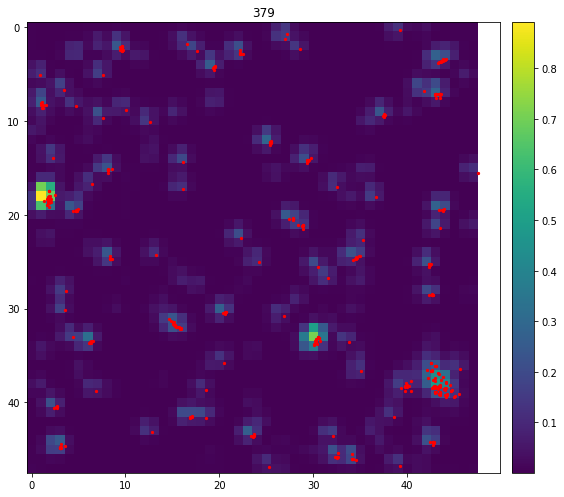

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(121)
im = plt.imshow(probs_inp[0,0].cpu().max(dim=0).values)
add_colorbar(im)
plt.title(len(out_df))
plt.scatter(out_df['x']/100,out_df['y']/100, color='red', s=5.)

In [ ]:
model_out = torch.load('../data/model_batch_output.pt')

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.plotting import plot_3d_projections
from decode_fish.engine.microscope import Microscope

psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/fishcod/simfish_psf.pkl')
_,xs,ys,zs = psf_state['psf_volume'].shape
psf = LinearInterpolatedPSF(fs_x=xs, fs_y=ys, fs_z=zs, upsample_factor= 1)
psf.load_state_dict(psf_state)

noise = sCMOS()

micro = Microscope(parametric_psf=[psf], noise=noise, multipl=10000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,1,48,48,48]).cuda()*.0001, min_int = 0.5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

TypeError: __init__() got an unexpected keyword argument 'fs_x'

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
xrec = micro(locs_mod, x_os_mod, y_os_mod, z_os_mod, ints_mod, output_shape_mod)

NameError: name 'micro' is not defined

In [ ]:
plot_3d_projections(xsim[0,0])

In [ ]:
plot_3d_projections(xrec[0,0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted index.ipynb.
